# Importing Packages

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.feature_selection import f_regression, RFE, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics

from scipy import stats
import pylab

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
#Writing output data into excel
output = pd.ExcelWriter('walmartsales1_output.xlsx')

# Creating UDF's

In [21]:
# Create Statistical Summary for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), len(x.value_counts()), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.50),
                      x.quantile(0.99),x.max()], 
                      index = ['Count', 'Unique', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN',
                               'P1', 'P50', 'P99' ,'MAX'])

In [22]:
# Create Statistical Summary for categorical variables
def categorical_var_summary(a):
    Mode = a.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([a.count(), a.isnull().sum(), len(a.value_counts()), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/a.count()), 2)], 
                      index = ['COUNT', 'MISS', 'UNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [23]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

# Importing Files

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

# Data Understanding

In [25]:
#Merging Datasets
t1 = train.merge(features, on = ['Store', 'Date', 'IsHoliday'])
train_data = t1.merge(stores, on = 'Store')

t2 = test.merge(features, on = ['Store', 'Date', 'IsHoliday'])
test_data= t2.merge(stores, on = 'Store')

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  Type          115064 non-null  object 
 14  Size          115064 non-null  int64  
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


In [28]:
#Data type converstion (Converting Date column to DateTime type)
train_data['Date'] = pd.to_datetime(train_data['Date'], format = '%Y-%m-%d')
test_data['Date'] = pd.to_datetime(test_data['Date'], format = '%Y-%m-%d')

In [29]:
#Extracting Date Features
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month


test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month


In [30]:
train_data['Week'] = train_data['Date'].dt.week
train_data['Day'] = train_data['Date'].dt.day


test_data['Week'] = test_data['Date'].dt.week
test_data['Day'] = test_data['Date'].dt.day

# EDA

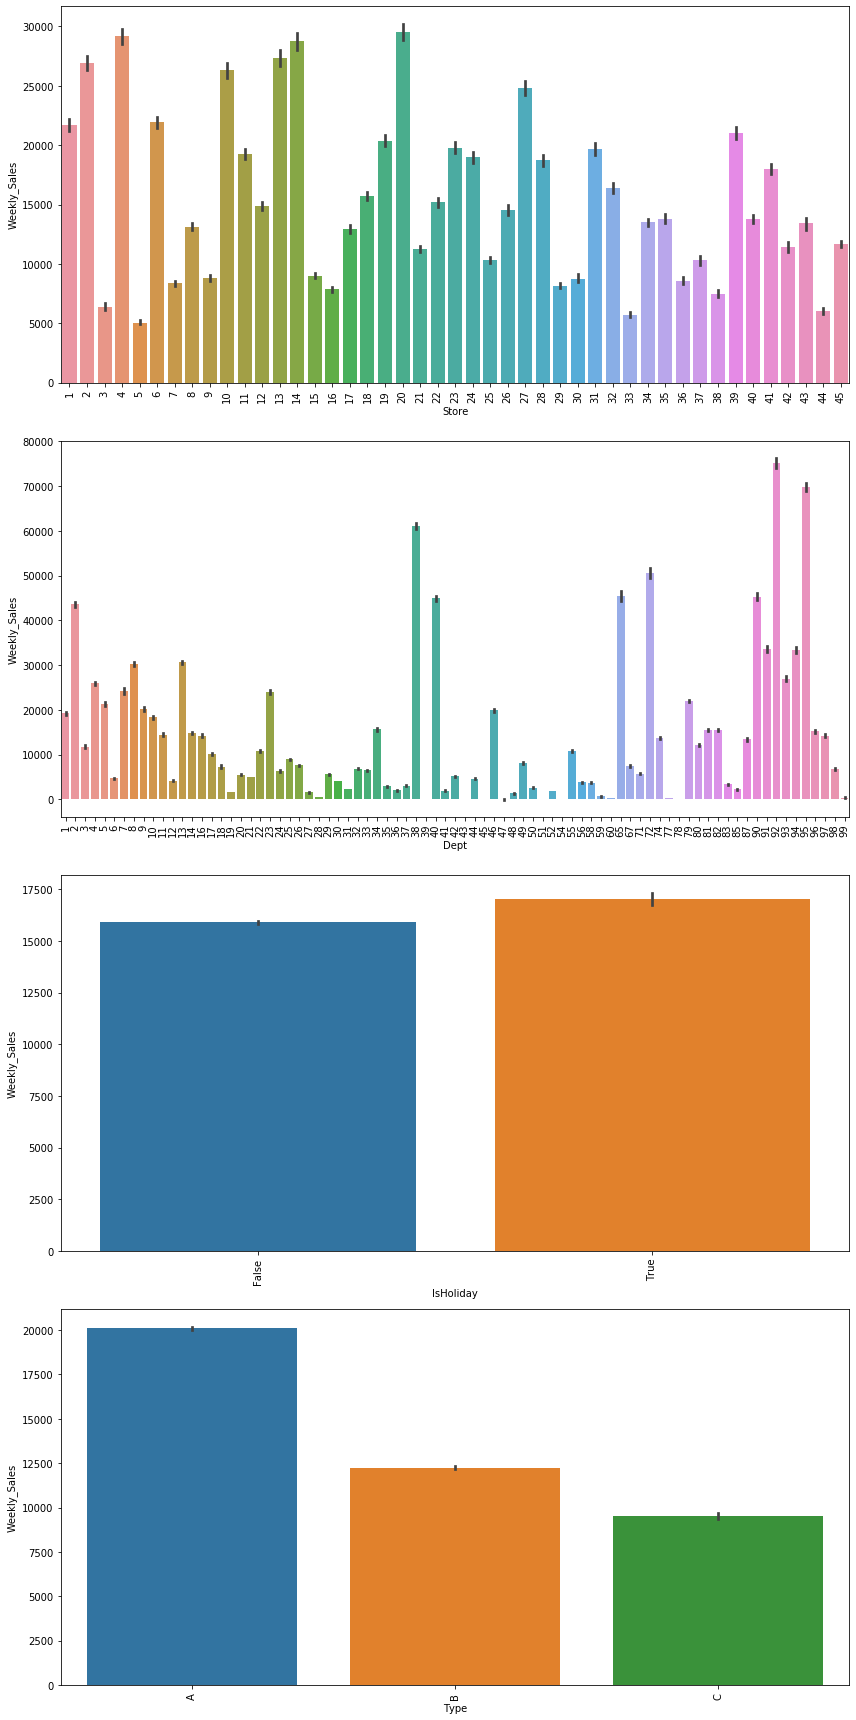

In [31]:
#Visualizing Weekly Sales across different categorical features
plt_cols = ['Store', 'Dept', 'IsHoliday', 'Type']

plt.figure(figsize = (12,24))
for i, col in enumerate(plt_cols):
    plt.subplot(4, 1, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = train_data[col], y = train_data.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout()

#### Analysing the Graph
> - If we analyse the weekly sales according to the store, Store 20 is showing highest weekly sales.
> - According to the Depatment wise sales, deparment 92 has the highest weekly sale.
> - During the holidays the sales are high.
> - Store Type A has the highest weekly sales.

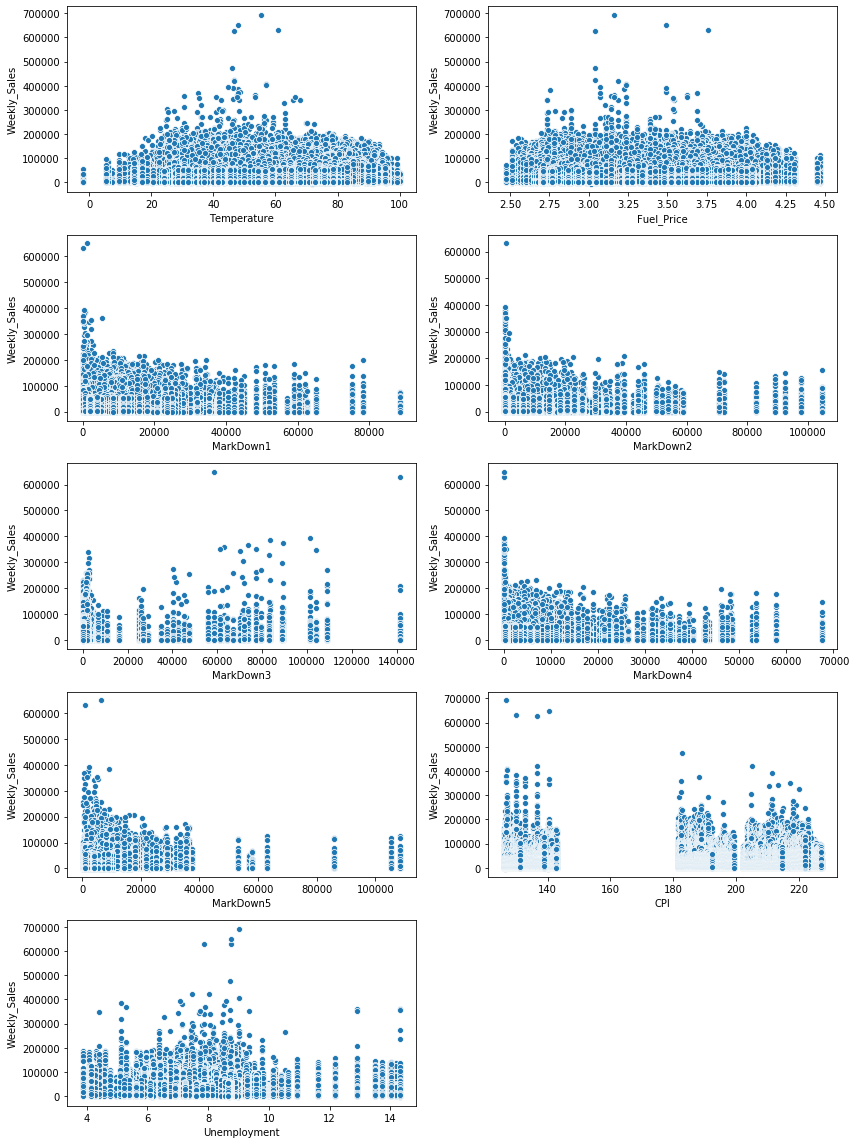

In [32]:
#Visualizing Weekly Sales across different continuous features
plt_cols = ['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
            'MarkDown4','MarkDown5','CPI','Unemployment']

plt.figure(figsize = (12,16))
for i, col in enumerate(plt_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(x = train_data[col], y = train_data.Weekly_Sales)
    plt.tight_layout() 

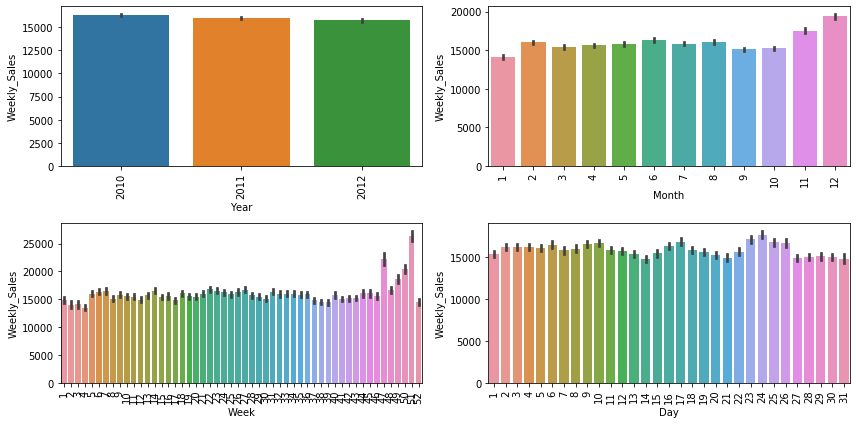

In [33]:
#Visualizing Weekly Sales across different date features
plt_cols = ['Year', 'Month','Week', 'Day']

plt.figure(figsize = (12,6))
for i, col in enumerate(plt_cols):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = train_data[col], y = train_data.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout() 

#### Observation:
> - In Year 2010, the weekly sales was high
> - During  the month of november and december, the weekly sales has increaseed.
> - weekly sale is high in week 47 and 50.


# Getting the Summaries

In [34]:
#Getting Categorical and continuous variables
cat_cols = ['Store','Dept','IsHoliday','Type','Year','Month','Week','Day']
cont_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size','MarkDown1','MarkDown2','MarkDown3',
             'MarkDown4','MarkDown5']

In [35]:
#Summary of train Categorical Variables
cat_sum_train = train_data[cat_cols].apply(categorical_var_summary)
cat_sum_train.to_excel(output, 'Train Statistical Summary', startrow = 3)
cat_sum_train

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day
COUNT,421570.00,421570.00,421570,421570,421570.0,421570.0,421570.00,421570.00
MISS,0.00,0.00,0,0,0.0,0.0,0.00,0.00
UNIQUE,45.00,81.00,2,3,3.0,12.0,52.00,31.00
MODE,13.00,1.00,False,A,2011.0,4.0,7.00,23.00
FREQ,10474.00,6435.00,391909,215478,153453.0,41332.0,8929.00,14801.00
PERCENT,2.48,1.53,92.96,51.11,36.4,9.8,2.12,3.51


In [36]:
#Summary of train Continuous Variables
cont_sum_train = train_data[cont_cols].apply(continuous_var_summary)
cont_sum_train.to_excel(output, 'Train Statistical Summary', startrow = 13)
cont_sum_train

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Count,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,4.215700e+05,1.506810e+05,1.112480e+05,1.370910e+05,1.349670e+05,1.514320e+05
Unique,3.594640e+05,3.528000e+03,8.920000e+02,2.145000e+03,3.490000e+02,4.000000e+01,2.277000e+03,1.499000e+03,1.662000e+03,1.944000e+03,2.293000e+03
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.708890e+05,3.103220e+05,2.844790e+05,2.866030e+05,2.701380e+05
SUM,6.737219e+09,2.533217e+07,1.416908e+06,7.217360e+07,3.355819e+06,5.764039e+10,1.091898e+09,3.709708e+08,1.973317e+08,4.566161e+08,7.009750e+08
MEAN,1.598126e+04,6.009006e+01,3.361027e+00,1.712019e+02,7.960289e+00,1.367279e+05,7.246420e+03,3.334629e+03,1.439421e+03,3.383168e+03,4.628975e+03
MEDIAN,7.612030e+03,6.209000e+01,3.452000e+00,1.823188e+02,7.866000e+00,1.401670e+05,5.347450e+03,1.920000e+02,2.460000e+01,1.481310e+03,3.359450e+03
STD,2.271118e+04,1.844793e+01,4.585145e-01,3.915928e+01,1.863296e+00,6.098058e+04,8.291221e+03,9.475357e+03,9.623078e+03,6.292384e+03,5.962887e+03
VAR,5.157979e+08,3.403262e+02,2.102356e-01,1.533449e+03,3.471872e+00,3.718632e+09,6.874435e+07,8.978240e+07,9.260364e+07,3.959410e+07,3.555603e+07
MIN,-4.988940e+03,-2.060000e+00,2.472000e+00,1.260640e+02,3.879000e+00,3.487500e+04,2.700000e-01,-2.657600e+02,-2.910000e+01,2.200000e-01,1.351600e+02
P1,5.000000e+00,1.830000e+01,2.565000e+00,1.261119e+02,4.156000e+00,3.487500e+04,1.776000e+01,-9.900000e-01,6.000000e-02,3.970000e+00,3.519700e+02


In [37]:
#Summary of test Categorical Variables
cat_summ_test = test_data[cat_cols].apply(categorical_var_summary)
cat_summ_test.to_excel(output, 'Test Statistical Summary', startrow = 3)
cat_summ_test

,Store,Dept,IsHoliday,Type,Year,Month,Week,Day
COUNT,115064.00,115064.00,115064,115064,115064.00,115064.00,115064.00,115064.00
MISS,0.00,0.00,0,0,0.00,0.00,0.00,0.00
UNIQUE,45.00,81.00,2,3,2.00,9.00,39.00,27.00
MODE,13.00,1.00,False,A,2013.00,11.00,51.00,7.00
FREQ,2836.00,1755.00,106136,58713,88275.00,14824.00,3002.00,5926.00
PERCENT,2.46,1.53,92.24,51.03,76.72,12.88,2.61,5.15


In [38]:
#Summary of test Continuous Variables
cont_summ_test = test_data[cont_cols[1:]].apply(continuous_var_summary)
cont_summ_test.to_excel(output, 'Test Statistical Summary', startrow = 13)
cont_summ_test

,Temperature,Fuel_Price,CPI,Unemployment,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Count,1.150640e+05,115064.000000,7.690200e+04,76902.000000,1.150640e+05,1.149150e+05,8.643700e+04,1.052350e+05,1.021760e+05,1.150640e+05
Unique,1.236000e+03,297.000000,3.600000e+02,89.000000,4.000000e+01,1.752000e+03,1.257000e+03,1.421000e+03,1.483000e+03,1.754000e+03
NMISS,0.000000e+00,0.000000,3.816200e+04,38162.000000,0.000000e+00,1.490000e+02,2.862700e+04,9.829000e+03,1.288800e+04,0.000000e+00
SUM,6.206760e+06,412107.046000,1.360868e+07,528219.318000,1.570597e+10,8.836063e+08,3.227602e+08,2.528890e+08,3.429250e+08,4.513594e+08
MEAN,5.394180e+01,3.581546,1.769613e+02,6.868733,1.364977e+05,7.689216e+03,3.734052e+03,2.403089e+03,3.356219e+03,3.922681e+03
MEDIAN,5.447000e+01,3.606000,1.923044e+02,6.806000,1.401670e+05,4.842290e+03,7.425900e+02,7.826000e+01,8.409400e+02,2.390430e+03
STD,1.872415e+01,0.239442,4.123997e+01,1.583427,6.110693e+04,1.069876e+04,8.323495e+03,1.376794e+04,7.570502e+03,1.944515e+04
VAR,3.505939e+02,0.057332,1.700735e+03,2.507242,3.734056e+09,1.144635e+08,6.928057e+07,1.895562e+08,5.731249e+07,3.781139e+08
MIN,-7.290000e+00,2.872000,1.312362e+02,3.684000,3.487500e+04,-2.781450e+03,-3.574000e+01,-1.792600e+02,2.200000e-01,-1.851700e+02
P1,1.144000e+01,2.957000,1.312794e+02,3.879000,3.487500e+04,2.084000e+01,2.000000e-02,1.500000e-01,2.610000e+00,2.693000e+02


# Data Preparation

In [39]:
#Handling Outliers
train_data[cont_cols] = train_data[cont_cols].apply(outlier_capping)

#Saving to excel
train_data[cont_cols].to_excel(output, 'Train Oulier Treatment')

test_data[cont_cols[1:]] = test_data[cont_cols[1:]].apply(outlier_capping)

#Saving to excel
test_data[cont_cols[1:]].to_excel(output, 'Test Oulier Treatment')

In [40]:
#Missing Values in train dataset
train_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Week                 0
Day                  0
dtype: int64

In [41]:
#Treating missing values in train dataset
train_data = train_data.fillna(0)

In [42]:
#Missing values in test dataset
test_data.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Month               0
Week                0
Day                 0
dtype: int64

In [43]:
#Treating Missing values in CPI and Unemployment with mean by Department wise for test dataset
test_data['CPI'] = test_data[['Store','Dept','CPI']].groupby(['Store','Dept'])['CPI'].transform(lambda x: x.interpolate())
test_data['Unemployment'] = test_data[['Store','Dept','Unemployment']].groupby(['Store','Dept'])['Unemployment'].transform(lambda x: x.interpolate())

In [44]:
#Imputing missing vaues in MarkDown with zeros for test dataset
test_data = test_data.fillna(0)

In [45]:
#Checking for missing values
train_data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [46]:
test_data.isna().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [47]:
#Saving to excel
train_data.to_excel(output, 'Train Missing Treatment')
test_data.to_excel(output, 'Test Missing Treatment')

In [48]:
#Changing categorical to numerical using Label Encoder
le = LabelEncoder()

train_data['IsHoliday'] = le.fit_transform(train_data.IsHoliday)
train_data['Type'] = le.fit_transform(train_data.Type)

#Saving to excel
train_data[['IsHoliday', 'Type']].to_excel(output, 'Train Encoded Variables')

test_data['IsHoliday'] = le.fit_transform(test_data.IsHoliday)
test_data['Type'] = le.fit_transform(test_data.Type)

#Saving to excel
test_data[['IsHoliday', 'Type']].to_excel(output, 'Test Encoded Variables')

#### Creating new Holiday variable based on given date

In [49]:
#Getting dates of Super Bowl, Labor
new_hdays = ['2010-02-12','2011-02-11','2012-02-10','2013-02-08',
             '2010-09-10','2011-09-09','2012-09-07','2013-09-06',
            '2010-11-26','2011-11-25','2012-11-23','2013-11-29',
            '2010-12-31','2011-12-30','2012-12-28','2013-12-27',]

In [50]:
#Adding new holidays to train and test dataset
train_data.loc[train.Date.isin(new_hdays), 'IsHoliday'] = 1
test_data.loc[test.Date.isin(new_hdays), 'IsHoliday'] = 1

In [51]:
#Checking for negative values
(train_data.drop(['Date'], axis =1)<0).any(0)

Store           False
Dept            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2        True
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
Year            False
Month           False
Week            False
Day             False
dtype: bool

In [52]:
#Replacing negative values in MarkDown2 with zeros
train_data.loc[train_data.MarkDown2<0,'MarkDown2'] = 0

In [53]:
#Dropping Date as it has no significance for our prediction model
train_data.drop('Date', axis = 1, inplace = True)
test_final = test_data.drop('Date', axis = 1)

In [54]:
#Droping Year and Month from train and test dataset to group the data at week level
train_data.drop(['Year', 'Month', 'Day'], axis = 1, inplace = True)
test_final.drop(['Year', 'Month', 'Day'], axis = 1, inplace = True)

In [55]:
train_data.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Week'],
      dtype='object')

In [56]:
#Grouping train data at Store, Department and Week level
train_data = train_data.groupby(['Store','Dept','Week']).agg({'Weekly_Sales': 'mean','IsHoliday' : 'max',
              'Temperature' : 'mean', 'Fuel_Price' : 'mean', 'MarkDown1' : 'mean',
              'MarkDown2' : 'mean', 'MarkDown3' : 'mean', 'MarkDown4' : 'mean',
              'MarkDown5' : 'mean', 'CPI' : 'mean', 'Unemployment' : 'mean',
              'Type' : lambda x: x.mode(), 'Size' : 'mean'}).reset_index()

In [57]:
#Saving final train and test dataset to excel
train_data.to_excel(output, 'Final Train Data')
test_final.to_excel(output, 'Final Test Data')

### Correlation Matrix

In [58]:
#Checking correlation with the dependant variable - Weekly_Sales
corr = train_data.corrwith(train['Weekly_Sales']).sort_values(ascending = False)
corr.to_excel(output, 'Correlation with Target')
corr

CPI             0.105427
Temperature     0.066740
MarkDown5       0.010117
IsHoliday       0.003468
Dept            0.002633
Week            0.002086
MarkDown3      -0.000778
MarkDown2      -0.014904
MarkDown4      -0.018073
MarkDown1      -0.020529
Size           -0.025058
Store          -0.027233
Unemployment   -0.032543
Weekly_Sales   -0.033525
Fuel_Price     -0.040666
Type           -0.048510
dtype: float64

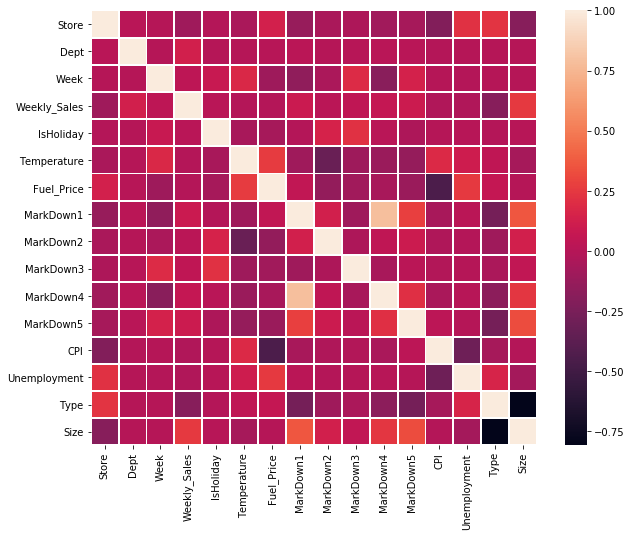

In [59]:
#Correlation matrix heatmap of train dataset
cm = train_data.corr()
cm.to_excel(output, 'Train Correlation Matrix')

plt.figure(figsize = (10,8))
sns.heatmap(cm, linewidths = 1)
plt.show()

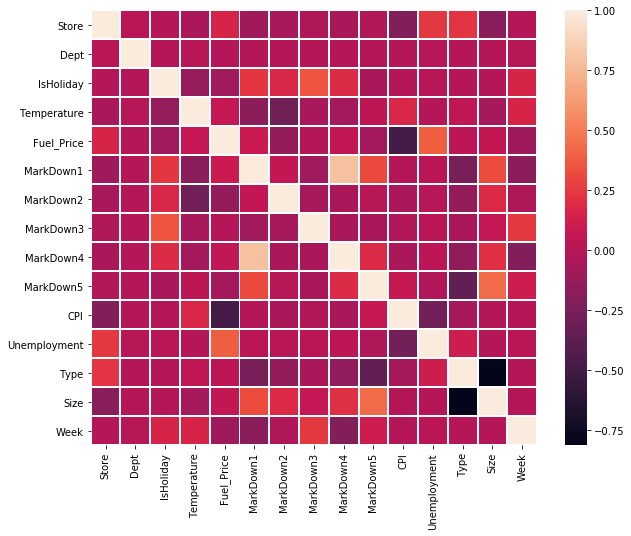

In [60]:
#Correlation matrix heatmap of test dataset
cm1 = test_final.corr()
cm1.to_excel(output, 'Test Correlation Matrix')

plt.figure(figsize = (10,8))
sns.heatmap(cm1, linewidths = 1)
plt.show()

## Feature Selection

In [61]:
#Defining X and Y
Y = train_data['Weekly_Sales']
X = train_data.drop(['Weekly_Sales'], axis = 1)

In [62]:
#Getting Model Formula
model_fm = '''Weekly_Sales ~ Store + Dept + Week + IsHoliday + Temperature + Fuel_Price +
              MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + CPI + Unemployment
              + Type + Size'''

In [63]:
## Separating the X and Y variables
target, predictor  = dmatrices(model_fm, train_data, return_type = 'dataframe')

#Calculating VIF for each X and saving in DataFrame
vif = pd.DataFrame()
vif['Features'] = predictor.columns
vif['VIF Factor'] = [variance_inflation_factor(predictor.values, i) for i in range(predictor.shape[1])]

vif.round(1).to_excel(output, 'VIF Result', index = True)

#Getting features
vif_cols = list(set(vif.Features).difference(['Intercept']))

#VIF output
vif.round(1)

,Features,VIF Factor
0,Intercept,480.1
1,Store,1.1
2,Dept,1.0
3,Week,1.2
4,IsHoliday,1.1
5,Temperature,1.5
6,Fuel_Price,1.6
7,MarkDown1,3.1
8,MarkDown2,1.2
9,MarkDown3,1.1


All the features have less than 4 VIF Factor i.e low multicollinearity. We can proceed with these features for building model.

# Building  Model

In [64]:
#Getting Train and Test dataset
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 123)

# Random Forest Model

In [65]:
#Setting Random Forest parameters
rf = RandomForestRegressor(n_estimators = 200, random_state = 123,
                           n_jobs = -1).fit(train_x, train_y)

In [66]:
#Making dataframes to store train and test predicted values 
tr = pd.DataFrame(train_y)
ts = pd.DataFrame(test_y)

#Predicting total spent on train and test dataset
tr.loc[:, 'rf_pred_sales'] = rf.predict(train_x)
ts.loc[:, 'rf_pred_sales'] = rf.predict(test_x)

In [67]:
#R-square Score
rf_r2 = metrics.r2_score(test_y, ts.rf_pred_sales)

print('R-square Score:', rf_r2)

#Getting Mean Squared Error Metric - MSE
rf_MSE_train = metrics.mean_squared_error(train_y, tr.rf_pred_sales)
rf_MSE_test = metrics.mean_squared_error(test_y, ts.rf_pred_sales)

print('\nTraining MSE:', rf_MSE_train,' | ','Testing MSE:', rf_MSE_test)

#Getting Root Mean Squared Error - RMSE
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_RMSE_test = np.sqrt(rf_MSE_test)

print('Training RMSE: ',rf_RMSE_train,' | ','Testing RMSE:',rf_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
rf_MAE_train = metrics.mean_absolute_error(train_y, tr.rf_pred_sales)
rf_MAE_test = metrics.mean_absolute_error(test_y, ts.rf_pred_sales)

print('\nTraining MAE:', rf_MAE_train, '|', 'Testing MAE:', rf_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
rf_MAPE_train = np.mean(np.abs(train_y - tr['rf_pred_sales'])/train_y)
rf_MAPE_test = np.mean(np.abs(test_y - ts['rf_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', rf_MAPE_train, '|', 'Testing MAPE:',rf_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
rf_RMSPE_train = np.sqrt(np.mean(((train_y - tr['rf_pred_sales'])/train_y)**2))
rf_RMSPE_test = np.sqrt(np.mean(((test_y - ts['rf_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', rf_RMSPE_train,' | ','Testing RMSPE:', rf_RMSPE_test)

R-square Score: 0.9806416817690738

Training MSE: 1211363.4051622075  |  Testing MSE: 8195943.4485947
Training RMSE:  1100.6195551425603  |  Testing RMSE: 2862.8558204343262

Training MAE: 482.5685961181994 | Testing MAE: 1289.6887944517068

Training MAPE: 0.448994503441091 | Testing MAPE: 0.9322101523301745

Training RMSPE: 23.832249551728513  |  Testing RMSPE: 22.95460761643819


In [68]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.rf_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.rf_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.998596544823853, 0.0) | Test Data:  (0.9902964808534, 0.0)


### Decile Analysis

In [69]:

#Creating Deciles
tr.loc[:, 'rf_Deciles'] = pd.qcut(tr.rf_pred_sales, 10, labels = False)
ts.loc[:, 'rf_Deciles'] = pd.qcut(ts.rf_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
rf_decile_train = tr.groupby(['rf_Deciles'])[['Weekly_Sales','rf_pred_sales']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
rf_decile_test = ts.groupby(['rf_Deciles'])[['Weekly_Sales','rf_pred_sales']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

In [70]:
rf_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=2, index = False)
rf_decile_train

,rf_Deciles,Weekly_Sales,rf_pred_sales
9,9,66209.698271,65817.447969
8,8,32262.157641,32304.542422
7,7,19814.503903,19911.790432
6,6,13216.868530,13343.341385
5,5,8817.628220,8901.306295
4,4,5686.335472,5765.421523
3,3,3435.722981,3495.138121
2,2,1748.155259,1798.495958
1,1,541.564521,577.251121
0,0,56.392501,64.129506


In [71]:
rf_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=6, index = False)
rf_decile_test

,rf_Deciles,Weekly_Sales,rf_pred_sales
9,9,65539.748241,65126.856927
8,8,32082.652131,32041.188918
7,7,19739.438211,19950.085827
6,6,13259.100676,13430.980640
5,5,8920.472409,9031.758053
4,4,5758.333368,5873.286697
3,3,3479.424773,3570.176428
2,2,1781.263955,1851.527444
1,1,561.530845,602.984457
0,0,67.393320,73.998791


<BarContainer object of 15 artists>

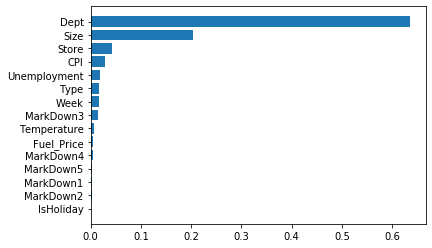

In [72]:
#Feature Impotance for Random Forest Model
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers', startrow=5, startcol=1, index = False)

plt.barh(width = rf_fi.Importance, y = rf_fi.Features)

# Gradient Boost Model

In [73]:
#Setting parameters
gb = GradientBoostingRegressor(n_estimators = 300, random_state = 123).fit(train_x, train_y)

In [74]:
#Predicting total spent on train and test dataset
tr.loc[:, 'gb_pred_sales'] = gb.predict(train_x)
ts.loc[:, 'gb_pred_sales'] = gb.predict(test_x)

In [75]:
#R-square Score
gb_r2 = metrics.r2_score(test_y, ts.gb_pred_sales)

print('R-square Score:', gb_r2)

#Getting Mean Squared Error Metric - MSE
gb_MSE_train = metrics.mean_squared_error(train_y, tr.gb_pred_sales)
gb_MSE_test = metrics.mean_squared_error(test_y, ts.gb_pred_sales)

print('\nTraining MSE:', gb_MSE_train,' | ','Testing MSE:', gb_MSE_test)

#Getting Root Mean Squared Error - RMSE
gb_RMSE_train = np.sqrt(gb_MSE_train)
gb_RMSE_test = np.sqrt(gb_MSE_test)

print('Training RMSE: ',gb_RMSE_train,' | ','Testing RMSE:',gb_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
gb_MAE_train = metrics.mean_absolute_error(train_y, tr.gb_pred_sales)
gb_MAE_test = metrics.mean_absolute_error(test_y, ts.gb_pred_sales)

print('\nTraining MAE:', gb_MAE_train, '|', 'Testing MAE:', gb_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
gb_MAPE_train = np.mean(np.abs(train_y - tr['gb_pred_sales'])/train_y)
gb_MAPE_test = np.mean(np.abs(test_y - ts['gb_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', gb_MAPE_train, '|', 'Testing MAPE:', gb_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
gb_RMSPE_train = np.sqrt(np.mean(((train_y - tr['gb_pred_sales'])/train_y)**2))
gb_RMSPE_test = np.sqrt(np.mean(((test_y - ts['gb_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', gb_RMSPE_train,' | ','Testing RMSPE:', gb_RMSPE_test)

R-square Score: 0.8549313927346014

Training MSE: 61012527.03254417  |  Testing MSE: 61419286.899320394
Training RMSE:  7811.051595818848  |  Testing RMSE: 7837.045801787839

Training MAE: 4968.387935758425 | Testing MAE: 5005.651016371407

Training MAPE: 21.761483870531812 | Testing MAPE: 20.606920106234867

Training RMSPE: 151.15234961900956  |  Testing RMSPE: 135.70501528393993


In [76]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.gb_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.gb_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.9280338456176207, 0.0) | Test Data:  (0.9271267892880981, 0.0)


### Decile Analysis

In [77]:

#Creating Deciles
tr.loc[:, 'gb_Deciles'] = pd.qcut(tr.gb_pred_sales, 10, labels = False)
ts.loc[:, 'gb_Deciles'] = pd.qcut(ts.gb_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
gb_decile_train = tr.groupby(['gb_Deciles'])[['Weekly_Sales','gb_pred_sales']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)
gb_decile_test = ts.groupby(['gb_Deciles'])[['Weekly_Sales','gb_pred_sales']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)

In [78]:
gb_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=10, index = False)
gb_decile_train

,gb_Deciles,Weekly_Sales,gb_pred_sales
9,9,63046.480530,58305.899727
8,8,30755.563535,30431.847535
7,7,19872.306389,19972.046942
6,6,13358.869150,14368.326324
5,5,8819.448990,10637.870461
4,4,6515.264953,7948.992611
3,3,4324.470939,5776.322899
2,2,2854.411107,3801.932947
1,1,1645.106010,1787.549679
0,0,598.553284,-1239.868044


In [79]:
gb_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=14, index = False)
gb_decile_test

,gb_Deciles,Weekly_Sales,gb_pred_sales
9,9,62846.108824,58173.889420
8,8,30607.491022,30142.634224
7,7,19601.799007,19881.265942
6,6,13275.912510,14387.046217
5,5,8852.304372,10643.033773
4,4,6637.150161,7970.038442
3,3,4311.914619,5794.035350
2,2,2835.019438,3804.758776
1,1,1628.426662,1754.270825
0,0,593.554579,-1231.938545


<BarContainer object of 15 artists>

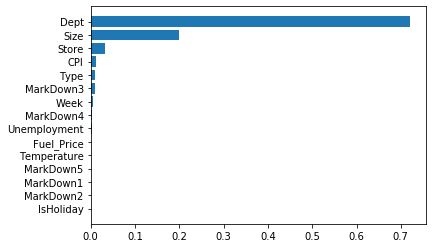

In [80]:
#Feature Impotance 
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gb.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

gb_fi.to_excel(output, 'Drivers', startrow=22, startcol=1, index = False)

plt.barh(width = gb_fi.Importance, y = gb_fi.Features)

# KNN Model

In [81]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_neighbors' : range(10,25,1)
              }

gscv_knn = GridSearchCV(estimator = KNeighborsRegressor(), 
                     param_grid = pg,
                     scoring = 'neg_mean_absolute_error',
                     cv = 14,
                     n_jobs = -1).fit(train_x, train_y)

In [82]:
#Best fit Parameters
gscv_knn.best_params_

{'n_neighbors': 10}

In [83]:
#Best Score
-1 * gscv_knn.best_score_

12063.256665632947

In [84]:
#Using best fit parameters to fit the model
knn = gscv_knn.best_estimator_

#Predicting total spent on train and test dataset
tr.loc[:, 'knn_pred_sales'] = gscv_knn.predict(train_x)
ts.loc[:, 'knn_pred_sales'] = gscv_knn.predict(test_x)

In [85]:
#R-square Score
knn_r2 = metrics.r2_score(test_y, ts.knn_pred_sales)

print('R-square Score:', knn_r2)

#Getting Mean Squared Error Metric - MSE
knn_MSE_train = metrics.mean_squared_error(train_y, tr.knn_pred_sales)
knn_MSE_test = metrics.mean_squared_error(test_y, ts.knn_pred_sales)

print('\nTraining MSE:', knn_MSE_train,' | ','Testing MSE:', knn_MSE_test)

#Getting Root Mean Squared Error - RMSE
knn_RMSE_train = np.sqrt(knn_MSE_train)
knn_RMSE_test = np.sqrt(knn_MSE_test)

print('Training RMSE: ',knn_RMSE_train,' | ','Testing RMSE:',knn_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
knn_MAE_train = metrics.mean_absolute_error(train_y, tr.knn_pred_sales)
knn_MAE_test = metrics.mean_absolute_error(test_y, ts.knn_pred_sales)

print('\nTraining MAE:', knn_MAE_train, '|', 'Testing MAE:', knn_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
knn_MAPE_train = np.mean(np.abs(train_y - tr['knn_pred_sales'])/train_y)
knn_MAPE_test = np.mean(np.abs(test_y - ts['knn_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', knn_MAPE_train, '|', 'Testing MAPE:', knn_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
knn_RMSPE_train = np.sqrt(np.mean(((train_y - tr['knn_pred_sales'])/train_y)**2))
knn_RMSPE_test = np.sqrt(np.mean(((test_y - ts['knn_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', knn_RMSPE_train,' | ','Testing RMSPE:', knn_RMSPE_test)

R-square Score: 0.19933950596288497

Training MSE: 271840625.8517049  |  Testing MSE: 338984412.4046163
Training RMSE:  16487.590055908866  |  Testing RMSE: 18411.52933367069

Training MAE: 10701.358222265206 | Testing MAE: 11996.334663784352

Training MAPE: 26.645770720220106 | Testing MAPE: 29.003242992542017

Training RMSPE: 241.20473173279592  |  Testing RMSPE: 229.8214311175857


In [86]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.knn_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.knn_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6011257987429236, 0.0) | Test Data:  (0.4591322557112481, 0.0)


### Decile Analysis

In [87]:

#Creating Deciles
tr.loc[:, 'knn_Deciles'] = pd.qcut(tr.knn_pred_sales, 10, labels = False)
ts.loc[:, 'knn_Deciles'] = pd.qcut(ts.knn_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
knn_decile_train = tr.groupby(['knn_Deciles'])[['Weekly_Sales','knn_pred_sales']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)
knn_decile_test = ts.groupby(['knn_Deciles'])[['Weekly_Sales','knn_pred_sales']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)

In [88]:
knn_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=10, index = False)
knn_decile_train

,knn_Deciles,Weekly_Sales,knn_pred_sales
9,9,43151.564207,42352.769224
8,8,27631.253161,26923.128904
7,7,20985.383834,20185.277388
6,6,16402.953155,16323.252695
5,5,13271.325071,13487.688480
4,4,10606.232115,11172.932443
3,3,8252.772444,8983.804954
2,2,6355.429742,6828.022883
1,1,4018.831680,4443.206339
0,0,1116.586175,1290.475826


In [89]:
knn_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=14, index = False)
knn_decile_test

,knn_Deciles,Weekly_Sales,knn_pred_sales
9,9,37416.373760,41809.062837
8,8,25777.450928,26736.397334
7,7,18281.323609,20056.211557
6,6,14821.733054,16237.905215
5,5,13324.007811,13545.681339
4,4,11690.016731,11340.796029
3,3,10064.244254,9224.531475
2,2,9065.077088,7071.418232
1,1,7366.502946,4680.336252
0,0,3393.085687,1418.324137


# Extra Tree Model

In [90]:
#Setting parameters
et = ExtraTreesRegressor(n_estimators = 100, random_state = 123,
                           n_jobs = -1).fit(train_x, train_y)

In [91]:
#Making dataframes to store train and test predicted values 
tr = pd.DataFrame(train_y)
ts = pd.DataFrame(test_y)

#Predicting total spent on train and test dataset
tr.loc[:, 'et_pred_sales'] = et.predict(train_x)
ts.loc[:, 'et_pred_sales'] = et.predict(test_x)

In [92]:
#R-square Score
et_r2 = metrics.r2_score(test_y, ts.et_pred_sales)
print('R-square Score:', et_r2)

#Getting Mean Squared Error Metric - MSE
et_MSE_train = metrics.mean_squared_error(train_y, tr.et_pred_sales)
et_MSE_test = metrics.mean_squared_error(test_y, ts.et_pred_sales)

print('\nTraining MSE:', et_MSE_train,' | ','Testing MSE:', et_MSE_test)

#Getting Root Mean Squared Error - RMSE
et_RMSE_train = np.sqrt(et_MSE_train)
et_RMSE_test = np.sqrt(et_MSE_test)

print('Training RMSE: ',et_RMSE_train,' | ','Testing RMSE:',et_RMSE_test)

#Getting Mean Absolute Error Metric - MAE
et_MAE_train = metrics.mean_absolute_error(train_y, tr.et_pred_sales)
et_MAE_test = metrics.mean_absolute_error(test_y, ts.et_pred_sales)

print('\nTraining MAE:', et_MAE_train, '|', 'Testing MAE:', et_MAE_test)

#Getting Mean Absolute Percentage Error - MAPE
et_MAPE_train = np.mean(np.abs(train_y - tr['et_pred_sales'])/train_y)
et_MAPE_test = np.mean(np.abs(test_y - ts['et_pred_sales'])/test_y)
                    
print('\nTraining MAPE:', et_MAPE_train, '|', 'Testing MAPE:', et_MAPE_test)

#Getting Root Mean Squared Percentage Error - RMSPE
et_RMSPE_train = np.sqrt(np.mean(((train_y - tr['et_pred_sales'])/train_y)**2))
et_RMSPE_test = np.sqrt(np.mean(((test_y - ts['et_pred_sales'])/test_y)**2))

print('\nTraining RMSPE:', et_RMSPE_train,' | ','Testing RMSPE:', et_RMSPE_test)

R-square Score: 0.9797466176294184

Training MSE: 1.1454260961315708e-21  |  Testing MSE: 8574896.56755733
Training RMSE:  3.384414419263059e-11  |  Testing RMSE: 2928.2924320424913

Training MAE: 1.7888627871069376e-11 | Testing MAE: 1314.1615204998852

Training MAPE: 1.148090624229905e-15 | Testing MAPE: 1.4150225782848647

Training RMSPE: 1.3547891630308512e-15  |  Testing RMSPE: 19.463287252353663


In [93]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_y, tr.et_pred_sales)
Corr_test = stats.stats.pearsonr(test_y, ts.et_pred_sales)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (1.0, 0.0) | Test Data:  (0.9898937607668439, 0.0)


### Decile Analysis

In [94]:
#Decile Analysis
#Creating Deciles
tr.loc[:, 'et_Deciles'] = pd.qcut(tr.et_pred_sales, 10, labels = False)
ts.loc[:, 'et_Deciles'] = pd.qcut(ts.et_pred_sales, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
et_decile_train = tr.groupby(['et_Deciles'])[['Weekly_Sales','et_pred_sales']].mean().reset_index().sort_values(by = 'et_Deciles', ascending = False)
et_decile_test = ts.groupby(['et_Deciles'])[['Weekly_Sales','et_pred_sales']].mean().reset_index().sort_values(by = 'et_Deciles', ascending = False)

In [95]:
et_decile_train.to_excel(output, 'Decile Analysis', startrow=4 , startcol=18, index = False)
et_decile_train

,et_Deciles,Weekly_Sales,et_pred_sales
9,9,66278.891394,66278.891394
8,8,32260.929910,32260.929910
7,7,19812.803740,19812.803740
6,6,13206.864986,13206.864986
5,5,8799.051027,8799.051027
4,4,5675.300217,5675.300217
3,3,3431.636514,3431.636514
2,2,1738.112894,1738.112894
1,1,534.922433,534.922433
0,0,50.511284,50.511284


In [96]:
et_decile_test.to_excel(output, 'Decile Analysis', startrow=4 , startcol=14, index = False)
et_decile_test

,et_Deciles,Weekly_Sales,et_pred_sales
9,9,65593.144257,64861.791578
8,8,32004.634472,31897.307221
7,7,19754.785866,19902.641005
6,6,13263.186876,13481.742726
5,5,8901.962302,9126.649757
4,4,5739.572166,6001.993392
3,3,3482.449972,3708.496944
2,2,1787.418136,1957.765329
1,1,584.342288,684.402142
0,0,77.859402,95.269120


<BarContainer object of 15 artists>

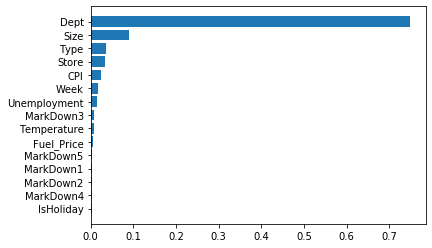

In [97]:
#Feature Impotance 
et_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : et.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

et_fi.to_excel(output, 'Drivers', startrow=39, startcol=1, index = False)

plt.barh(width = et_fi.Importance, y = et_fi.Features)

## Evaluating the different metrics for each model

In [98]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['RandomForestRegressor', 'GradientBoostingRegressor','KNNRegeressor', 'ExtraTreeRegressor'],
                        'Test_R2 Score' : [rf_r2, gb_r2,knn_r2, et_r2],
                        'MAE_train' : [rf_MAE_train, gb_MAE_train,knn_MAE_train, et_MAE_train],
                        'MAE_test' : [rf_MAE_test, gb_MAE_test, knn_MAE_test,et_MAE_test],
                        'MSE_train' : [rf_MSE_train, gb_MSE_train,knn_MSE_train, et_MSE_train],
                        'MSE_test' : [rf_MSE_test, gb_MSE_test,knn_MSE_test, et_MSE_test],   
                        'RMSE_train' : [rf_RMSE_train, gb_RMSE_train, knn_RMSE_train, et_RMSE_train],
                        'RMSE_test' : [rf_RMSE_test, gb_RMSE_test, knn_RMSE_test,et_RMSE_test],
                        'RMSPE_train' : [rf_RMSPE_train, gb_RMSPE_train, knn_RMSPE_train,et_RMSPE_train],  
                        'RMSPE_test' : [rf_RMSPE_test, gb_RMSPE_test,knn_RMSPE_test, et_RMSPE_test]
                        })

In [99]:
model_data.round(2).to_excel(output, 'Metrics of Models', index = False)
model_data

,Regressor,Test_R2 Score,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSPE_train,RMSPE_test
0,RandomForestRegressor,0.980642,4.825686e+02,1289.688794,1.211363e+06,8.195943e+06,1.100620e+03,2862.855820,2.383225e+01,22.954608
1,GradientBoostingRegressor,0.854931,4.968388e+03,5005.651016,6.101253e+07,6.141929e+07,7.811052e+03,7837.045802,1.511523e+02,135.705015
2,KNNRegeressor,0.199340,1.070136e+04,11996.334664,2.718406e+08,3.389844e+08,1.648759e+04,18411.529334,2.412047e+02,229.821431
3,ExtraTreeRegressor,0.979747,1.788863e-11,1314.161520,1.145426e-21,8.574897e+06,3.384414e-11,2928.292432,1.354789e-15,19.463287


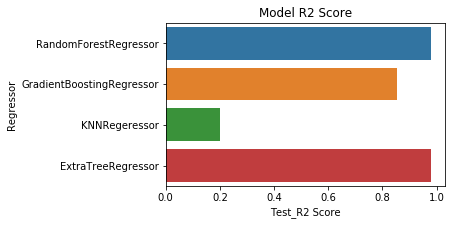

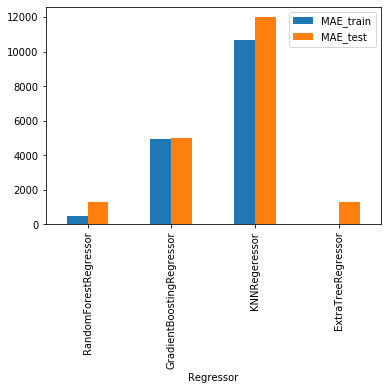

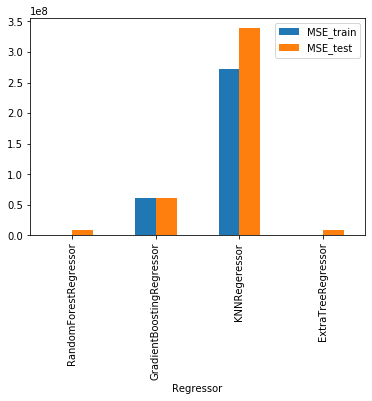

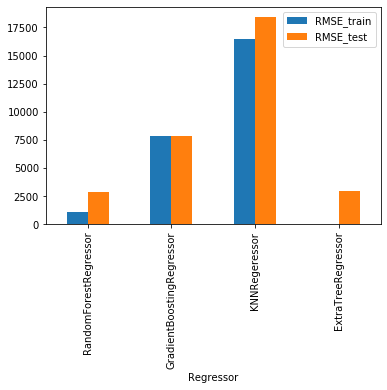

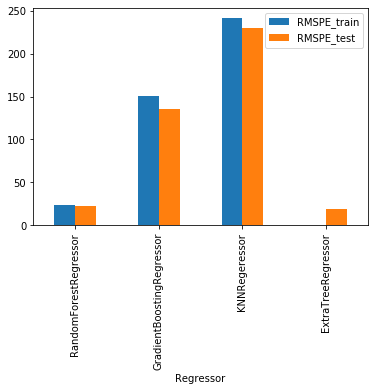

In [100]:
#Visualizing different metrics of the models
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['Test_R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')

model_data.plot(x = 'Regressor', y = ['MAE_train', 'MAE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['MSE_train', 'MSE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSE_train', 'RMSE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSPE_train', 'RMSPE_test'], kind = 'bar')

plt.show()

Random Forest Model performs best on train dataset. We can use Random Forest Model to predict Weekly Sales for Walmart Stores.

### Final Prediction

In [101]:
# Making Final Prediction on provided test dataset using Random Forest Model
test['Weekly_Sales'] = rf.predict(test_final)

final_pred = pd.DataFrame({
             'Id' : test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
             'Weekly_Sales' : test.Weekly_Sales
                        })

#Saving prediction on test dataset to excel
final_pred.to_excel(output, 'Predicted Weekly Sales', index = False)

In [102]:
#Predicted Weekly Sales
final_pred

,Id,Weekly_Sales
0,1_1_2012-11-02,9435.903625
1,1_1_2012-11-09,9324.038092
2,1_1_2012-11-16,4538.704400
3,1_1_2012-11-23,10853.577942
4,1_1_2012-11-30,10968.208333
...,...,...
115059,45_98_2013-06-28,10814.962058
115060,45_98_2013-07-05,23655.287692
115061,45_98_2013-07-12,29957.582283
115062,45_98_2013-07-19,6959.721883


In [ ]:
output.save()